In [1]:
import sys
import os

if sys.version_info[0] < 3:
  print('[ERROR] You need to run this with Python 3.')
  raise AssertionError

In [2]:
import numpy as np

import functools
import itertools
import toolz

from emtf_algos import *
from emtf_logger import get_logger
from emtf_colormap import get_colormap

In [3]:
# Set random seed
np.random.seed(2027)

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as k_layers
from tensorflow.keras import backend as k_backend
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set random seed
tf.random.set_seed(2027)

import numba
from numba import njit, vectorize
import dask
import dask.array as da

logger = get_logger()
logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using python     : {0}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(tf.config.list_physical_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))
logger.info('Using numba      : {0}'.format(numba.__version__))
logger.info('Using dask       : {0}'.format(dask.__version__))

assert k_backend.backend() == 'tensorflow'
assert k_backend.image_data_format() == 'channels_last'

%matplotlib inline

[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using python     : 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) [GCC 7.3.0]
[INFO    ] Using numpy      : 1.19.2
[INFO    ] Using tensorflow : 2.4.0
[INFO    ] Using keras      : 2.4.0
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using matplotlib : 3.3.2
[INFO    ] Using numba      : 0.51.2
[INFO    ] Using dask       : 2020.12.0


In [4]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

# masked array filling value
ma_fill_value = 999999

#maxevents = 10
maxevents = -1

#workers = 1
workers = 8

# Input files
features_fname = 'features_zone%i.h5' % zone


# Scheduler
dask.config.set(scheduler='threads', num_workers=workers)

# Styling
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

logger.info('Processing zone {0} timezone {1}'.format(zone, timezone))
logger.info('.. maxevents        : {0}'.format(maxevents))
logger.info('.. workers          : {0}'.format(workers))

[INFO    ] Processing zone 0 timezone 0
[INFO    ] .. maxevents        : -1
[INFO    ] .. workers          : 8


### Load data

In [5]:
import h5py
file_handles = []

def load_features():
  features = []
  truths = []
  for i in range(num_emtf_zones):
    fname = features_fname.replace('zone%i' % zone, 'zone%i' % i)  # modify filename
    logger.info('Loading from {0}'.format(fname))
    loaded = h5py.File(fname, 'r')
    file_handles.append(loaded)
    features.append(da.from_array(loaded['features']))
    truths.append(da.from_array(loaded['truths']))
  features = da.concatenate(features, axis=0)
  truths = da.concatenate(truths, axis=0)
  features = np.array(features)  # lazy no more
  truths = np.array(truths)  # lazy no more
  logger.info('features: {0} truths: {1}'.format(features.shape, truths.shape))
  logger.info('features: {0} truths: {1}'.format(features.dtype, truths.dtype))
  return features, truths

In [6]:
# Load features and truths
features, truths = load_features()

for file_handle in file_handles:  # close files
  file_handle.close()

[INFO    ] Loading from features_zone0.h5
[INFO    ] Loading from features_zone1.h5
[INFO    ] Loading from features_zone2.h5
[INFO    ] features: (1751565, 40) truths: (1751565, 9)
[INFO    ] features: int32 truths: float32


### Map & filter

In [7]:
@njit
def apply_train_rules(x):
  # Rules:
  # 1. theta_median != 0 and trk_qual != 0
  # 2. at least one station-1 hit (ME1/1, GE1/1, ME1/2, RE1/2, ME0)
  #    with the following requirements on station-2,3,4
  #    2a. if there is ME1/1 or GE1/1, require 2 more stations
  #    2b. if there is ME1/2 or RE1/2, require 1 more station
  #    2c. if there is ME0,
  #        - if there is ME1/1 or GE1/1, require 1 more station
  #        - else, require 2 more stations
  ind_emtf_theta = (num_emtf_sites * 1)
  ind_emtf_theta_end = (num_emtf_sites * 2)
  ind_theta_median = (num_emtf_sites * 3) + 1
  ind_trk_qual = (num_emtf_sites * 3) + 2
  stations = np.array([11, 12, 2, 3, 4, 12, 2, 3, 4, 11, 2, 0], dtype=np.int32)
  assert(len(stations) == (ind_emtf_theta_end - ind_emtf_theta))
  assert(x.ndim == 1 and x.shape[0] == num_emtf_features)

  boolean_mask = (x[ind_emtf_theta:ind_emtf_theta_end] != ma_fill_value)
  rule1 = np.all(np.array([(x[ind_theta_median] != 0), (x[ind_trk_qual] != 0)]))

  cnt_me0 = np.any(boolean_mask[stations == 0])    # ME0
  cnt_me11 = np.any(boolean_mask[stations == 11])  # ME1/1, GE1/1
  cnt_me12 = np.any(boolean_mask[stations == 12])  # ME1/2, RE1/2
  cnt_me2 = np.sum(np.array([
      np.any(boolean_mask[stations == 2]),         # ME2, GE2/1, RE2
      np.any(boolean_mask[stations == 3]),         # ME3, RE3
      np.any(boolean_mask[stations == 4]),         # ME4, RE4
  ]))
  rule2_a = np.all(np.array([cnt_me11 >= 1, cnt_me2 >= 2]))
  rule2_b = np.all(np.array([cnt_me12 >= 1, cnt_me2 >= 1]))
  rule2_c = np.any(np.array([
      np.all(np.array([cnt_me0 >= 1, cnt_me11 >= 1, cnt_me2 >= 1])),
      np.all(np.array([cnt_me0 >= 1, cnt_me2 >= 2])),
  ]))
  rule2 = np.any(np.array([rule2_a, rule2_b, rule2_c]))

  passed = np.all(np.array([rule1, rule2]))
  return passed

def train_filter(features, truths):
  passed = np.apply_along_axis(apply_train_rules, 1, features)
  (features, truths) = (x[passed] for x in (features, truths))
  return (features, truths)

In [8]:
# Apply filtering
features, truths = train_filter(features, truths)

logger.info('features: {0} truths: {1}'.format(features.shape, truths.shape))
logger.info('features: {0} truths: {1}'.format(features.dtype, truths.dtype))

[INFO    ] features: (1590732, 40) truths: (1590732, 9)
[INFO    ] features: int32 truths: float32


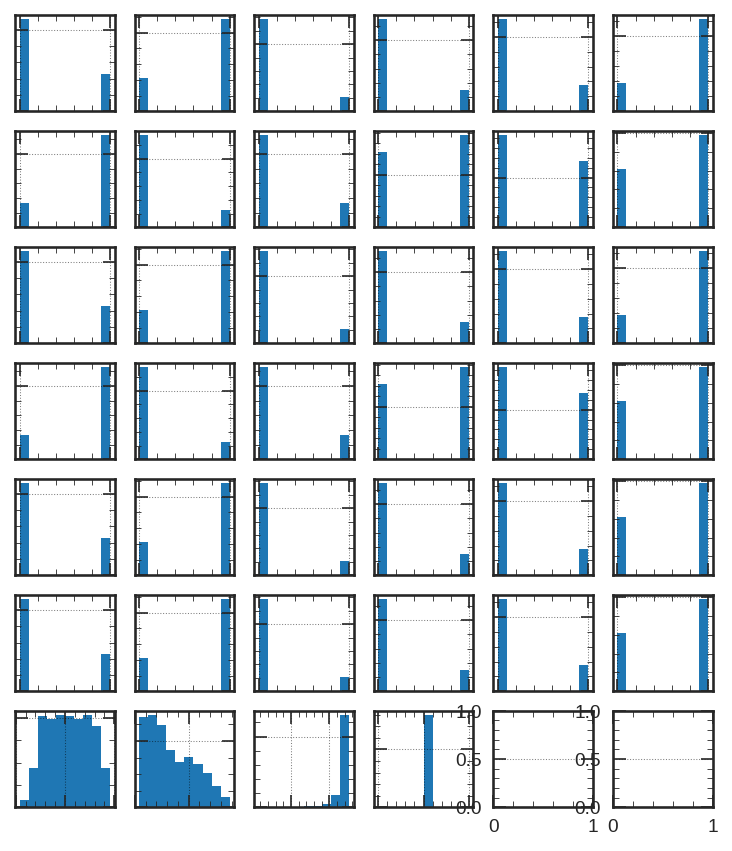

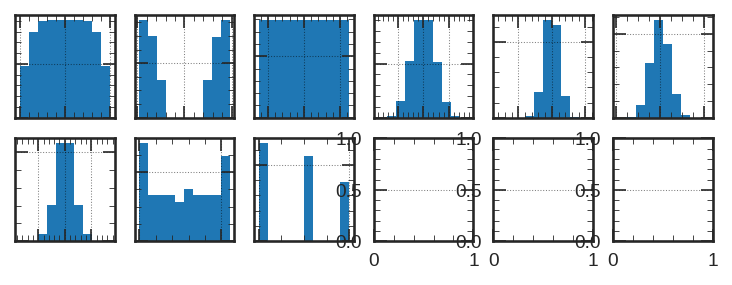

In [9]:
# Check features and truths

def doit():
  fig, axs = plt.subplots(ni, nj, figsize=(6,6*ni/nj))
  for i in range(ni):
    for j in range(nj):
      ij = (i * nj) + j
      if ij >= nij:
        break
      #
      if axs.ndim == 2:
        ax = axs[i, j]
      elif axs.ndim == 1:
        ax = axs[j]
      else:
        ax = axs
      ax.hist(axdata[:, ij])
      ax.set_xticklabels([])
      ax.set_yticklabels([])

ni, nj = 7, 6
nij = features.shape[1]
axdata = features
doit()

ni, nj = 2, 6
nij = truths.shape[1]
axdata = truths
doit()

plt.show()

In [10]:
# Write to file
if maxevents == -1:
  outfile = 'features_merge.h5'
  outdict = {'features': da.from_array(features), 'truths': da.from_array(truths)}
  da.to_hdf5(outfile, outdict, compression='lzf')
  logger.info('Wrote to {0}'.format(outfile))

[INFO    ] Wrote to features_merge.h5
